In [ ]:
##Implemented using guidance from from https://medium.com/analytics-vidhya/pytorch-implementation-of-semantic-segmentation-for-single-class-from-scratch-81f96643c98c

In [1]:
!pip install segmentation_models_pytorch

from fastai.vision import *
from PIL import Image as PImage
import cv2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import os
#import pdb
import time
import warnings
import random
import concurrent.futures
# warning print supression
warnings.filterwarnings("ignore")

seed = 12
random.seed(seed)
torch.manual_seed(seed)

     |████████████████████████████████| 42 kB 425 kB/s 
     |████████████████████████████████| 58 kB 2.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=d40755bc16853b61ce557a91b3b78dc88396d148e44f534ff2471bcf5a05fadc
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=22f71f0bfaa7462525cc05c77f1e177c9004051f2819c2428d34df4c4a4947e3
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# List of images
ims = glob.glob('/input/opencitiestrain/data/images-256/*.png')
df = pd.DataFrame({
    'img_path':ims,
    'mask_path':[im.replace('images', 'masks').replace('.png', '_mask.png') for im in ims],
    'valid':False
})
# Add columns
df['img_id'] = df['img_path'].apply(lambda x: x.split('/input/opencitiestrain/data/images-256/')[1].split(".png")[0])
df['scene_id'] = df['img_path'].apply(lambda x: x.split("_")[1])
df['area'] = df['img_path'].apply(lambda x: x.split("_")[0].split("/")[-1])
df['prot'] = 0
df.loc[df['area'] == 'dar', 'prot'] = 1

In [4]:
# Set random validation set
df.loc[df.sample(n=5000, random_state=39).index, 'valid'] = 'True'

In [6]:
df_valid = df[df.valid == 'True']
df_train = df[df.valid != 'True']

In [9]:
# Convert the high resolution image mask to 128*128
!mkdir train_masks-128
def resize_mask(fn):
    PIL.Image.open('/input/opencitiestrain/data/masks-256/' + fn + '_mask.png').resize((128,128), resample=PIL.Image.NEAREST).save('train_masks-128/' + fn + '_mask.png')

files = list(df['img_id'])
with concurrent.futures.ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

# # # Convert the high resolution input image to 128*128
!mkdir train-128
def resize_img(fn):
    PIL.Image.open('/input/opencitiestrain/data/images-256/' + fn + '.png').resize((128,128)).save('train-128/' + fn + '.png')

files = list(df['img_id'])
with concurrent.futures.ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [10]:
# location of original and mask image
img_fol='train-128/'
mask_fol='train_masks-128/'
# imagenet mean/std will be used as the resnet backbone is trained on imagenet stats
mean, std=(0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [11]:
'''when dataloader request for samples using index it fetches input image and target mask,
apply transformation and returns it'''
class ImgDataset(Dataset):
    def __init__(self,df,img_fol,mask_fol,mean,std,phase):
        self.fname=df['img_id'].values.tolist()
        self.prot=df['prot'].values.tolist()
        self.img_fol=img_fol
        self.mask_fol=mask_fol
        self.mean=mean
        self.std=std
        self.phase=phase
    def __getitem__(self, idx):
        name=self.fname[idx]
        prot=self.prot[idx] 
        prot_tensor = torch.Tensor(128)
        prot_tensor = prot_tensor.fill_(prot)
        img_name_path=os.path.join(self.img_fol,name)
        img_name_path = img_name_path + '.png'
        mask_name_path=img_name_path.split('.')[0].replace('train-128','train_masks-128')+'_mask.png'
        img=cv2.imread(img_name_path)
        mask=cv2.imread(mask_name_path,cv2.IMREAD_GRAYSCALE)
        mask = mask.transpose()
        #convert to binary mask
        mask = mask/255
        mask = np.expand_dims(mask, axis=0)
        img = img.transpose()
        return img, mask, prot_tensor, name

    def __len__(self):
        return len(self.fname)

In [12]:
def ImgDataloader(df_train,df_valid,img_fol,mask_fol,mean,std,phase,batch_size):
    df = df_train if phase=='train' else df_valid
    for_loader=ImgDataset(df, img_fol, mask_fol, mean, std, phase)
    dataloader=DataLoader(for_loader, batch_size=batch_size, pin_memory = False)

    return dataloader

In [14]:
class Trainer(object):
    def __init__(self,model):
        self.num_workers=4
        self.batch_size={'train':64, 'val':1}
        self.accumulation_steps= 1
        self.lr=0.01
        self.num_epochs=20
        self.phases=['train','val']
        self.best_loss=float('inf')
        self.device=torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net=model.to(self.device)
        self.criterion=torch.nn.BCEWithLogitsLoss()
        self.optimizer=optim.Adam(self.net.parameters(),lr=self.lr)
        self.dataloaders={phase: ImgDataloader(df_train, df_valid, img_fol,
                                               mask_fol, mean, std,
                                               phase=phase,batch_size=self.batch_size[phase]) for phase in self.phases}

        self.losses={phase:[] for phase in self.phases}
        self.jacc_score={phase:[] for phase in self.phases}

    def forward(self, inp_images, tar_mask):
        inp_images=inp_images.float()  
        inp_images=inp_images.to(self.device)
        tar_mask=tar_mask.to(self.device)
        tar_mask=tar_mask.float()
        pred_mask=self.net(inp_images)
        loss=self.criterion(pred_mask,tar_mask)
        return loss, pred_mask

    def iterate(self, epoch, phase):
        start=time.strftime("%H:%M:%S")
        print (f"Starting epoch: {epoch} | phase:{phase} | Start Time: {start}")
        batch_size=self.batch_size[phase]
        self.net.train(phase=="train")
        dataloader=self.dataloaders[phase]
        running_loss=0.0
        total_batches=len(dataloader)
        self.optimizer.zero_grad()
        for itr,batch in enumerate(dataloader):
            images,mask_target,prot, name =batch
            loss, pred_mask=self.forward(images,mask_target)
            loss=loss/self.accumulation_steps
            if phase=='train':
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            running_loss+=loss.item()
            pred_mask=pred_mask.detach().cpu()
        epoch_loss=(running_loss*self.accumulation_steps)/total_batches
        print("Loss: ", epoch_loss)
        self.losses[phase].append(epoch_loss)
        torch.cuda.empty_cache()
        return epoch_loss
    def start(self):
        for epoch in range (self.num_epochs):
            self.iterate(epoch,"train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss=self.iterate(epoch,"val")
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model_office.pth")
            print ()

In [15]:
# Train the baseline model
device = torch.device("cuda")
model = smp.Unet("resnet18", encoder_weights=None, classes=1, activation=None)
model.to(device)
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase:train | Start Time: 13:30:00
Loss:  0.17692205568461894
Starting epoch: 0 | phase:val | Start Time: 13:31:07
Loss:  0.1752648038152593
******** New optimal found, saving state ********

Starting epoch: 1 | phase:train | Start Time: 13:31:52
Loss:  0.15214529031842844
Starting epoch: 1 | phase:val | Start Time: 13:32:56
Loss:  0.17262937933788822
******** New optimal found, saving state ********

Starting epoch: 2 | phase:train | Start Time: 13:33:40
Loss:  0.1441404591106467
Starting epoch: 2 | phase:val | Start Time: 13:34:44
Loss:  0.13470930686246413
******** New optimal found, saving state ********

Starting epoch: 3 | phase:train | Start Time: 13:35:28
Loss:  0.1354131658155074
Starting epoch: 3 | phase:val | Start Time: 13:36:32
Loss:  0.1571803093854042

Starting epoch: 4 | phase:train | Start Time: 13:37:15
Loss:  0.12768245094113334
Starting epoch: 4 | phase:val | Start Time: 13:38:19
Loss:  0.14522395075756767

Starting epoch: 5 | phase:train | Start

In [16]:
# Run the model on the validation set
test_dataloader=ImgDataloader(df_train, df_valid,img_fol,mask_fol,mean,std,'val',1)

ckpt_path='model_office.pth'

device = torch.device("cuda")
model = smp.Unet("resnet18", encoder_weights=None, classes=1, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

# save the validation predictions and masks into an array
predictions = []
probs = []
masks = []
prots = []
names = []
for i, batch in enumerate(test_dataloader):
    images,mask_target, prot, name = batch
    images, mask_target = images.to(device), mask_target.to(device)
    images = images.float()
    batch_probs = torch.sigmoid(model(images))
    batch_preds = torch.round(batch_probs)
    batch_preds = batch_preds.detach().cpu().numpy()
    batch_probs = batch_probs.detach().cpu().numpy()
    predictions.append(batch_preds)
    probs.append(batch_probs)
    mask = mask_target.detach().cpu().numpy()
    masks.append(mask)
    names.append(name)
    prot_flat = np.full_like((predictions[0].flatten()), prot[0][0].cpu())
    prots.append(prot_flat)

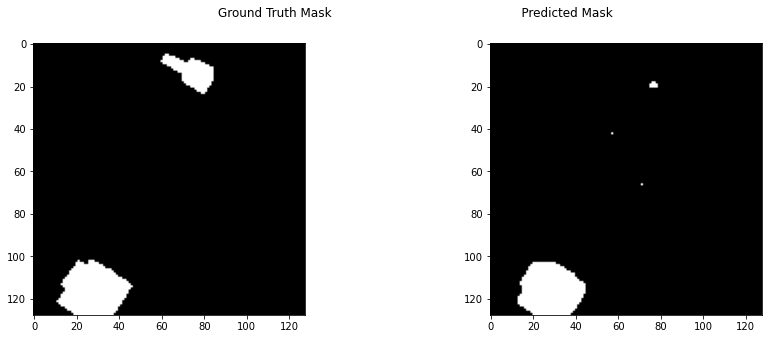

In [19]:
# Visualise some results
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
fig.suptitle('                Ground Truth Mask                                                 Predicted Mask')
orig_array = np.reshape(masks[4672], (128,128))
orig_array = np.round(orig_array)
orig_array = np.rot90(orig_array, k=3)
orig_array = np.flip(orig_array, axis=1)
ax1.imshow(np.squeeze(orig_array),cmap='gray')
pred_array = np.reshape(predictions[4672], (128,128))
pred_array = np.round(pred_array)
pred_array = np.rot90(pred_array, k=3)
pred_array = np.flip(pred_array, axis=1)
ax2.imshow(np.squeeze(pred_array),cmap='gray')
plt.show()

In [23]:
# Save results to csv for input into the post-processing model

preds_list = np.vstack(predictions)
preds_list = preds_list.flatten()

prots_list = np.vstack(prots)
prots_list = prots_list.flatten()

masks_list = np.vstack(masks)
masks_list = masks_list.flatten()

probs_list = np.vstack(probs)
probs_list = probs_list.flatten()

data = np.concatenate((np.expand_dims(probs_list, 1), np.expand_dims(masks_list, 1), np.expand_dims(prots_list, 1)), axis=1)

test_and_val_data = pd.DataFrame(data=data, columns = ['prediction','label', 'group'])

print(test_and_val_data.head())

test_and_val_data.to_csv('test_and_val_data.csv',encoding='utf-8', columns=['prediction','label', 'group'], index=False)

names_df = pd.DataFrame(data=names, columns = ['name'])
names_df.to_csv('names')